This script tests the trained Gaussian process regression model on the month of June on the 10 intersections on which the model was trained. Thus, this script tests the model's gap-filling performance, since the model was trained using data sampled uniformly from May and July.

In [1]:
from __future__ import print_function
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.close('all')
warnings.filterwarnings("ignore")

In [2]:
#%% Validation in terms of time: gap-filling
filename = 'gprPedsMdl.pickle'
gprPedsMdl = pickle.load(open(filename, 'rb'))

filename = 'gprCycsMdl.pickle'
gprCycsMdl = pickle.load(open(filename, 'rb'))

filename = 'PedestriansData.sav'
Pedestrians = pickle.load(open(filename, 'rb'))

filename = 'CyclistsData.sav'
Cyclists = pickle.load(open(filename, 'rb'))

filename = 'testInts.sav'
testInts = pickle.load(open(filename, 'rb')) # Hold-out intersection IDs

testInts represents the hold-out intersections, thus the actual trained intersections are recovered as below:

In [3]:
#Extracting the intersections used for training
allInts = list(np.arange(0,14)) #all intersections
trainInts = list(set(allInts) - set(testInts)) #trained intersections

Pedestrians and traffic data are collected together in a list as below in order to separately test their performance:

In [4]:
RoadUser = ['Pedestrians', 'Cyclists']

trafficData = [Pedestrians, Cyclists]

gprMdls = [gprPedsMdl, gprCycsMdl] #Gaussian process regression models

Evaluating the performance for each of the 10 intersections on the month of June, for pedestrians and cylists

RMSE: 300.58748495423276
R_Squared: 0.1723238503576634


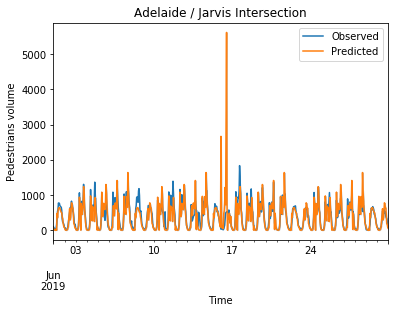

RMSE: 220.52107682428226
R_Squared: -3.0068160945746074


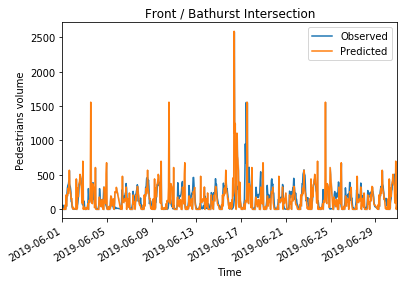

RMSE: 436.78887928796667
R_Squared: 0.7228358750907928


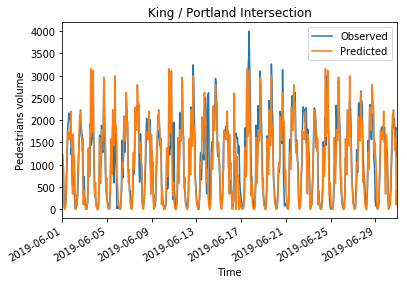

RMSE: 1160.0276595121918
R_Squared: 0.7085302128571789


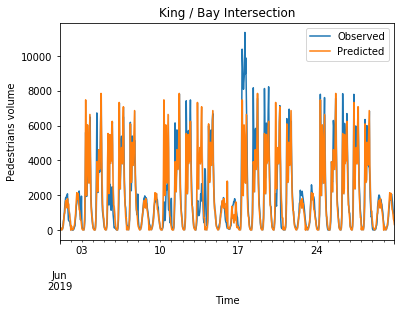

RMSE: 628.0395997776644
R_Squared: 0.8552718657447251


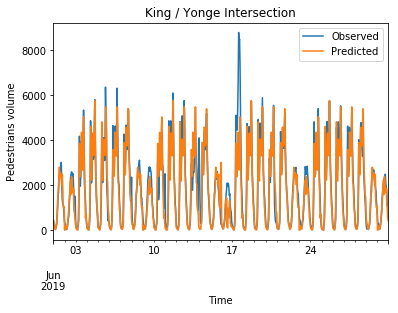

RMSE: 347.09121239556356
R_Squared: 0.7062627856107002


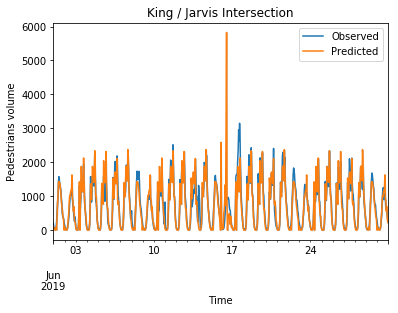

RMSE: 484.1967783524571
R_Squared: 0.7572156939205567


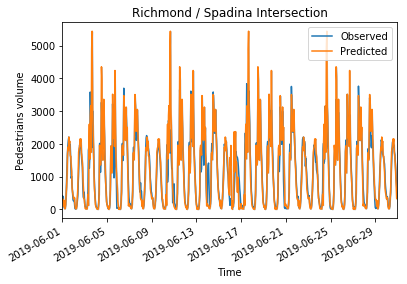

RMSE: 947.6513965823322
R_Squared: 0.6415927545452662


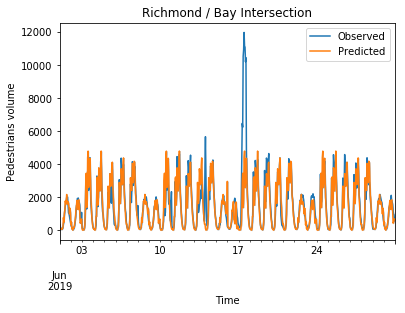

RMSE: 320.84512356394515
R_Squared: 0.5533626725105656


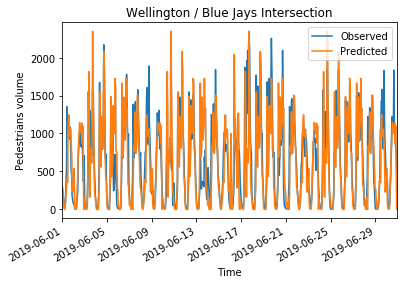

RMSE: 643.3888266029311
R_Squared: 0.7906374566703793


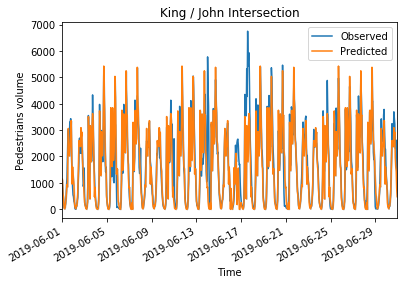

RMSE: 34.62840414495553
R_Squared: -2.4333470813695444


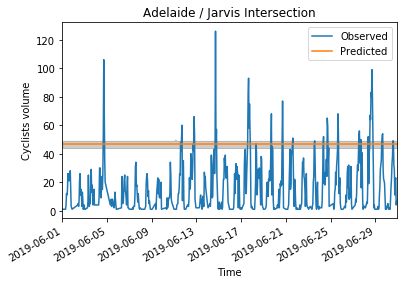

RMSE: 33.6736696921252
R_Squared: -4.793685334175397


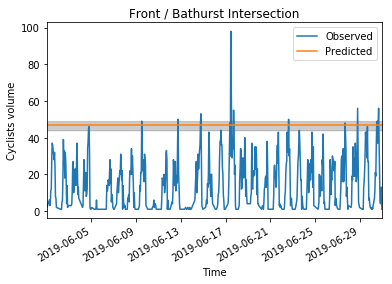

RMSE: 59.12050869483427
R_Squared: -0.11302439998669178


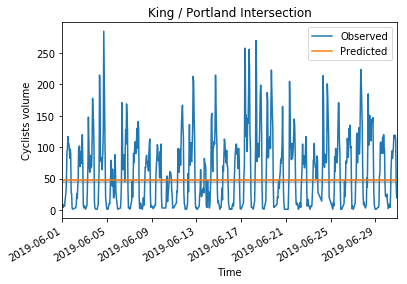

RMSE: 42.005605175282646
R_Squared: -0.014286130847971368


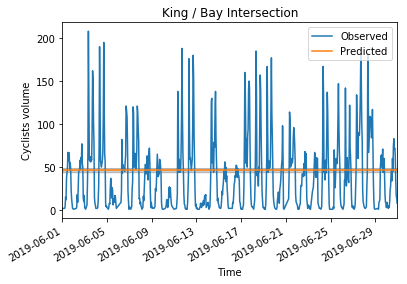

RMSE: 55.446675615928555
R_Squared: -0.022166773145110952


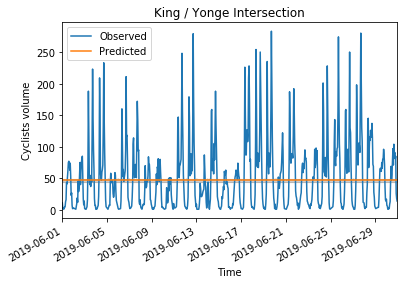

RMSE: 49.62767809144951
R_Squared: -0.0034258351459506287


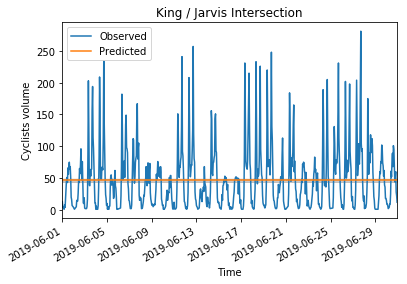

RMSE: 32.46598931848136
R_Squared: -0.39789065634987253


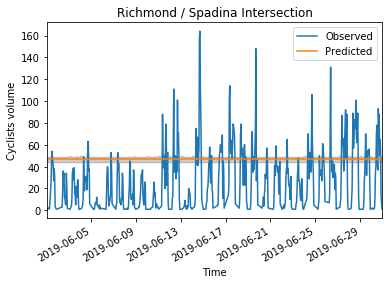

RMSE: 79.43850887151221
R_Squared: -0.09499485695781873


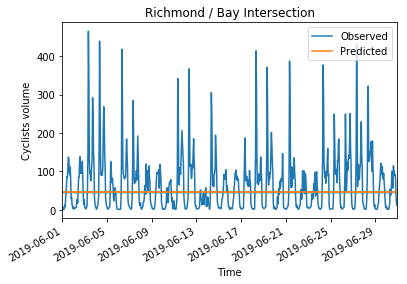

RMSE: 33.06117523757286
R_Squared: -2.88829619952297


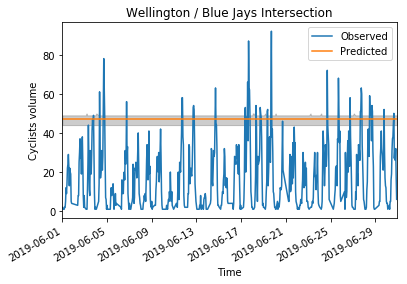

RMSE: 53.663173728405845
R_Squared: -0.03797574599622


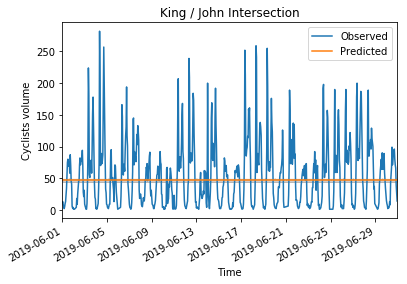

In [5]:
for j in range(2):
    
    gprMdl = gprMdls[j] #Selecting Gaussian process regression model 
    #for pedestrian or cyclists
    
    testData = trafficData[j]    
    
    for k in trainInts:
        
        testTraffic = testData[k];
        
        IntersectionName = testTraffic['IntName'][0]
        
        #Evaluating the hold-out set on the month of June for which 
        #the intersections were not trained for gap-filling
        
        testStart = pd.to_datetime('2019-06-01 00:00:00');
        testEnd = pd.to_datetime('2019-06-30 23:00:00');
        
        testTraffic = testTraffic[testStart: testEnd]
            
        testTraffic = testTraffic.dropna()
        
        X_test = testTraffic[['Hour','DayOfWeek','isHoliday','lat','lng']];
        
        y_test = testTraffic['volume']
        
        yPred, yStd = gprMdl.predict(X_test, return_std = True)
        yPred = yPred.astype('int'); yPred[yPred<0]=0
        
        yPred = pd.DataFrame(yPred, columns =['forecast']); 
        yPred.index = y_test.index; yPred = yPred['forecast'];
        
        print('RMSE: '+str(np.sqrt(np.mean((yPred.values - y_test.values)**2))))
        print('R_Squared: '+str(gprMdl.score(X_test, y_test)))
        
        #Plus/minus 3 times the standard deviation is used in order to show the 99.7% confidence bound 
        #of the predictions
        yLow = yPred - 3*yStd; yLow = yLow.astype('int'); yLow[yLow<0]=0
        yHigh = yPred + 3*yStd; yHigh = yHigh.astype('int');

        #Plotting for the month of June               
        plt.figure(j+k+1)
        ax = y_test.plot(label = 'Observed')
        yPred.plot(ax = ax, label = 'Predicted')
        ax.fill_between(y_test.index,
                            yLow,
                            yHigh, color='k', alpha=.2)
        ax.set_xlabel('Time')
        ax.set_ylabel(RoadUser[j]+ ' volume')
        ax.set_title(IntersectionName+ ' Intersection')
        plt.legend()
        plt.show()